In [1]:
# Homework_4 / Nov. 2020  / Kangyan Xu
# np.set_printoptions(threshold = 1200)

import numpy as np
from sklearn.cluster import KMeans
from munkres import Munkres
import time

In [2]:
from scipy.io import loadmat

start_time = time.time()
data = loadmat('aca5.mat')
cluster_num = 7 # np.max(s)

# shape[n_features ,n_samples]
X = data['X'] # (42, 1747) data points
s = data['s'] # (1, 1747) true class

# pick every other column
X = X[:, ::2] # (42, 874)
s = s[:, ::2] # (1, 874)

In [3]:
from sklearn.preprocessing import normalize
X = normalize(X, axis = 0, norm = 'l2')

# Transpose
X = X.T # (874,42)
s = s.flatten() # (874,)

# print(np.sum(X[0]**2))

In [4]:
# Build the kernel K part I

data_num = X.shape[0] # 874
l2_dist = np.zeros((data_num, data_num))

for i in range(data_num):
    for j in range(data_num):
        l2_dist[i,j] = np.square(np.linalg.norm(X[i]-X[j]))

In [5]:
def Spectral_Cluster(X, r, k, cluster_num):
    data_num = X.shape[0] # 874
    K = np.zeros((data_num, data_num))
    
    # Build the kernel K part II
    for i in range(data_num):
        for j in range(data_num):
            K[i,j] = np.exp(-r * X[i,j])
            
    # Pick the top k entries in each column       
    sort_index = np.argsort(-K, axis=0) # index array sorted from large to small
    
    W_temp = np.zeros((data_num, data_num))
    for i in range(data_num):
        W_temp[0:k,i] = K[sort_index[0:k,i],i] # Pick the top k largest entries in K
    
    W = (W_temp + W_temp.T)/2.0
    
    # Calcualte diagonal matrix D whose (i,i) element is the sum of W's i'th row
    # Calculate L = D^(-1/2) A D^(-1/2)
    
    D_entry = np.sum(W, axis=1)
    D_pow = np.diag(1.0/np.power(D_entry, 0.5))
    L = np.dot(np.dot(D_pow, W), D_pow)
    L = (L+L.T)/2.0
    
    # Find cluster_num largest eigenvectors of L
    
    evalues, evectors = np.linalg.eigh(L) # evalues sorted from small to large
    
    # evalues_topk = np.real(evalues[:-cluster_num-1:-1])
    evectors_topk = np.real(evectors[:, :-cluster_num-1:-1]) # Pick last k largest evectors, (874,7)
    
    Y = normalize(evectors_topk, axis = 1, norm = 'l2')
    
    kmean = KMeans(n_clusters = cluster_num)
    kmean.fit(Y)
    label = kmean.labels_
    
    return label

In [6]:
# Project: MvDSCN   Author: huybery   File: metric.py   License: MIT License

def best_map(L1, L2):
    #L1 should be the groundtruth labels and L2 should be the clustering labels we got
    Label1 = np.unique(L1)
    nClass1 = len(Label1)
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2 

In [7]:
# Calculate Misclassification error

def Misclassification_error(true_label, cluster_label):
    cluster_label_new = best_map(true_label, cluster_label)
    error_points_num = np.sum(true_label[:] != cluster_label_new[:])
    misclassified_rate = error_points_num / cluster_label_new.shape[0]
    return misclassified_rate

In [8]:
# 1st row is min error, 2nd row is corresponding r

error = np.zeros((2,49))

In [9]:
for k in range (2,51):
    min_error = 1
    min_r = 0

    for r in range (1,10):
        label = Spectral_Cluster(l2_dist, 0.1*r, k, cluster_num)
        temp = Misclassification_error(s, label)
        if min_error > temp:
            min_error = temp
            min_r = 0.1*r
        
    for r in range (1,101):
        label = Spectral_Cluster(l2_dist, r, k, cluster_num)
        temp = Misclassification_error(s, label)
        if min_error > temp:
            min_error = temp
            min_r = r
    
    print(min_error, min_r)
    error[0,k-2] = min_error
    error[1,k-2] = min_r

0.7437070938215103 8
0.7528604118993135 70
0.7276887871853547 16
0.7254004576659039 16
0.6819221967963387 11
0.6613272311212814 19
0.6544622425629291 17
0.6453089244851259 14
0.6430205949656751 8
0.6430205949656751 9
0.648741418764302 0.4
0.6350114416475973 5
0.6224256292906178 11
0.620137299771167 15
0.61441647597254 13
0.6064073226544623 13
0.5995423340961098 18
0.5903890160183066 12
0.5812356979405034 17
0.5846681922196796 17
0.5846681922196796 16
0.5812356979405034 12
0.5675057208237986 20
0.5594965675057209 24
0.5560640732265446 20
0.5537757437070938 25
0.5503432494279176 17
0.5446224256292906 19
0.545766590389016 16
0.5446224256292906 16
0.545766590389016 18
0.545766590389016 21
0.5434782608695652 32
0.5434782608695652 33
0.5446224256292906 31
0.5423340961098398 30
0.5434782608695652 8
0.5297482837528604 9
0.5183066361556065 10
0.517162471395881 10
0.5091533180778032 11
0.5137299771167048 13
0.5022883295194508 10
0.5 13
0.5011441647597255 12
0.5 15
0.4977116704805492 14
0.4954233

In [10]:
error

array([[ 0.74370709,  0.75286041,  0.72768879,  0.72540046,  0.6819222 ,
         0.66132723,  0.65446224,  0.64530892,  0.64302059,  0.64302059,
         0.64874142,  0.63501144,  0.62242563,  0.6201373 ,  0.61441648,
         0.60640732,  0.59954233,  0.59038902,  0.5812357 ,  0.58466819,
         0.58466819,  0.5812357 ,  0.56750572,  0.55949657,  0.55606407,
         0.55377574,  0.55034325,  0.54462243,  0.54576659,  0.54462243,
         0.54576659,  0.54576659,  0.54347826,  0.54347826,  0.54462243,
         0.5423341 ,  0.54347826,  0.52974828,  0.51830664,  0.51716247,
         0.50915332,  0.51372998,  0.50228833,  0.5       ,  0.50114416,
         0.5       ,  0.49771167,  0.49542334,  0.49313501],
       [ 8.        , 70.        , 16.        , 16.        , 11.        ,
        19.        , 17.        , 14.        ,  8.        ,  9.        ,
         0.4       ,  5.        , 11.        , 15.        , 13.        ,
        13.        , 18.        , 12.        , 17.        , 17.

In [11]:
time = time.time()-start_time
print("The run time is %.2f" %time)

The run time is 7414.43


In [12]:
np.save("aca5_errorrate.npy", error)

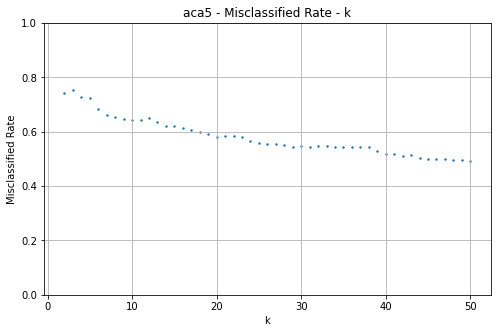

In [13]:
# fig
%matplotlib inline 
import matplotlib.pyplot as plt

axis_x = np.linspace(2, 50, 49)
plt.figure(figsize = (8, 5))
plt.scatter(axis_x, error[0,:], s = 8, marker = '.')
plt.ylim(0, 1)

#plt.legend(['Misclassified Rate'])
plt.title('aca5 - Misclassified Rate - k')
plt.xlabel('k')
plt.ylabel('Misclassified Rate')
plt.grid(True)
plt.savefig('aca5 - Misclassified Rate - k.png')
plt.show()

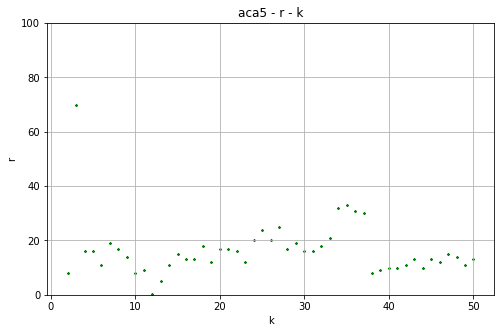

In [14]:
# fig

axis_x = np.linspace(2, 50, 49)
plt.figure(figsize = (8, 5))
plt.scatter(axis_x, error[1,:], s = 4, marker = '*', c='green')
plt.ylim(0, 100)

#plt.legend(['r'])
plt.title('aca5 - r - k')
plt.xlabel('k')
plt.ylabel('r')
plt.grid(True)
plt.savefig('aca5 - r - k.png')
plt.show()